<a href="https://colab.research.google.com/github/Raj-1566/AI-Powered-Identity-Verification-and-Fraud-Detection-for-KYC-Compliance/blob/main/Modelling_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 # Import Libraries
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
!pip install fuzzywuzzy python-Levenshtein
from fuzzywuzzy import fuzz


In [ ]:
# Load CSV (only first 500 rows)
file_path = "/content/sample_data/Synthetic_merged_cleaned.csv"

df = pd.read_csv(file_path).head(2000)
print("✅ Data loaded successfully! Shape:", df.shape)
print(df.head())

✅ Data loaded successfully! Shape: (2000, 6)
             Name  Gender         DOB Document_Type Document_Number  \
0  Mohanlal Sinha   Other  04-08-1975      Passport        K3935412   
1       Emir Gola    Male  12-03-1993           PAN      CCXHG1852M   
2    Krish D’Alia  Female  11-12-1974           PAN      QDBHD4336T   
3     Sana Khatri   Other         NaN      Passport        V9387476   
4  Raghav Mahajan  Female  28-12-1977       Aadhaar  8961 3216 2241   

                                             Address  
0            866, Borah Street, Hubli–Dharwad-639425  
1             H.No. 19, De Zila, North Dumdum 451695  
2             H.No. 993, Sur Street, Uluberia 045795  
3  H.No. 00, Vasa Nagar, Bhalswa Jahangir Pur-818798  
4                 75/993, Sahota Road, Rampur-792972  


#  Data Cleaning & Preprocessing

---


 Removing any kind of special character and loweracsing all the letters to find similarity between two rows later on.

In [ ]:

# Clean Name data
df['Name_clean'] = df['Name'].str.lower().apply(lambda x: re.sub(r'[^a-z\s]', '', str(x)))

# Clean Address Data
df['Address_clean'] = df['Address'].str.lower().apply(lambda x: re.sub(r'[^a-z0-9\s]', '', str(x)))
df.head()

# Clean Gender data
df['Gender_clean'] = df['Gender'].str.lower().apply(lambda x: re.sub(r'[^a-z\s]', '', str(x)))
df.head()

# Clean Document_Type
df['Document_type_clean'] = df['Document_Type'].str.lower().apply(lambda x: re.sub(r'[^a-z0-9\s]', '', str(x)))
df.head()



,Name,Gender,DOB,Document_Type,Document_Number,Address,Name_clean,Address_clean,Gender_clean,Document_type_clean
0,Mohanlal Sinha,Other,04-08-1975,Passport,K3935412,"866, Borah Street, Hubli–Dharwad-639425",mohanlal sinha,866 borah street hublidharwad639425,other,passport
1,Emir Gola,Male,12-03-1993,PAN,CCXHG1852M,"H.No. 19, De Zila, North Dumdum 451695",emir gola,hno 19 de zila north dumdum 451695,male,pan
2,Krish D’Alia,Female,11-12-1974,PAN,QDBHD4336T,"H.No. 993, Sur Street, Uluberia 045795",krish dalia,hno 993 sur street uluberia 045795,female,pan
3,Sana Khatri,Other,NaN,Passport,V9387476,"H.No. 00, Vasa Nagar, Bhalswa Jahangir Pur-818798",sana khatri,hno 00 vasa nagar bhalswa jahangir pur818798,other,passport
4,Raghav Mahajan,Female,28-12-1977,Aadhaar,8961 3216 2241,"75/993, Sahota Road, Rampur-792972",raghav mahajan,75993 sahota road rampur792972,female,aadhaar


In [ ]:
#  Replace empty or NaN values
df = df.fillna('')

# Optional: For DOB column, replace with placeholder
df['DOB'] = df['DOB'].replace('', 'Unknown')

# Optional: For Document_Number, replace missing with placeholder
df['Document_Number'] = df['Document_Number'].replace('', 'Missing')

In [ ]:
df.head()

,Name,Gender,DOB,Document_Type,Document_Number,Address,Name_clean,Address_clean,Gender_clean,Document_type_clean
0,Mohanlal Sinha,Other,04-08-1975,Passport,K3935412,"866, Borah Street, Hubli–Dharwad-639425",mohanlal sinha,866 borah street hublidharwad639425,other,passport
1,Emir Gola,Male,12-03-1993,PAN,CCXHG1852M,"H.No. 19, De Zila, North Dumdum 451695",emir gola,hno 19 de zila north dumdum 451695,male,pan
2,Krish D’Alia,Female,11-12-1974,PAN,QDBHD4336T,"H.No. 993, Sur Street, Uluberia 045795",krish dalia,hno 993 sur street uluberia 045795,female,pan
3,Sana Khatri,Other,NaN,Passport,V9387476,"H.No. 00, Vasa Nagar, Bhalswa Jahangir Pur-818798",sana khatri,hno 00 vasa nagar bhalswa jahangir pur818798,other,passport
4,Raghav Mahajan,Female,28-12-1977,Aadhaar,8961 3216 2241,"75/993, Sahota Road, Rampur-792972",raghav mahajan,75993 sahota road rampur792972,female,aadhaar


#  Document Validation (Aadhaar / PAN  /Passport)

Validating document numbers with their unique format.
Example: adhaar has 12 no, pan has mix of alphanumeric and numeric letter.

In [ ]:

def validate_document(doc_num, doc_type):
    doc_num = str(doc_num).strip()
    doc_type = str(doc_type).lower() # Convert to string and then to lower case
    if doc_type == 'aadhaar':
        return bool(re.match(r'^\d{12}$', doc_num))
    elif doc_type == 'pan':
        return bool(re.match(r'^[A-Z]{5}[0-9]{4}[A-Z]$', doc_num))
    elif doc_type == 'passport':
        return bool(re.match(r'^[A-Z]{1}[0-9]{7}$', doc_num))
    else:
        return False

df['Document_format'] = df.apply(lambda x: validate_document(x['Document_Number'], x['Document_Type']), axis=1)
df.head()

,Name,Gender,DOB,Document_Type,Document_Number,Address,Name_clean,Address_clean,Gender_clean,Document_type_clean,Document_format
0,Mohanlal Sinha,Other,04-08-1975,Passport,K3935412,"866, Borah Street, Hubli–Dharwad-639425",mohanlal sinha,866 borah street hublidharwad639425,other,passport,True
1,Emir Gola,Male,12-03-1993,PAN,CCXHG1852M,"H.No. 19, De Zila, North Dumdum 451695",emir gola,hno 19 de zila north dumdum 451695,male,pan,True
2,Krish D’Alia,Female,11-12-1974,PAN,QDBHD4336T,"H.No. 993, Sur Street, Uluberia 045795",krish dalia,hno 993 sur street uluberia 045795,female,pan,True
3,Sana Khatri,Other,NaN,Passport,V9387476,"H.No. 00, Vasa Nagar, Bhalswa Jahangir Pur-818798",sana khatri,hno 00 vasa nagar bhalswa jahangir pur818798,other,passport,True
4,Raghav Mahajan,Female,28-12-1977,Aadhaar,8961 3216 2241,"75/993, Sahota Road, Rampur-792972",raghav mahajan,75993 sahota road rampur792972,female,aadhaar,False


# Combining all important field into one single text
Merging all the important distinct data together to form a single text, which will help in similarity detection.Every letter is lowercased but Keeping Document_Number as it is because it is a case sensitive and unique attribute

In [ ]:

df["Combined_Data"] = (
    df["Name_clean"].astype(str) + " " +
    df["Gender_clean"].astype(str) + " " +
    df["DOB"].astype(str) + " " +
    df["Document_type_clean"].astype(str) + " " +
    df["Document_Number"].astype(str) + " " +  # keep case-sensitive
    df["Address_clean"].astype(str)
).str.replace(r"[^a-zA-Z0-9 ]", "", regex=True)  # keep letters in original case for Document_Number




In [ ]:
df.head()

,Name,Gender,DOB,Document_Type,Document_Number,Address,Name_clean,Address_clean,Gender_clean,Document_type_clean,Document_format,Combined_Data
0,Mohanlal Sinha,Other,04-08-1975,Passport,K3935412,"866, Borah Street, Hubli–Dharwad-639425",mohanlal sinha,866 borah street hublidharwad639425,other,passport,True,mohanlal sinha other 04081975 passport K393541...
1,Emir Gola,Male,12-03-1993,PAN,CCXHG1852M,"H.No. 19, De Zila, North Dumdum 451695",emir gola,hno 19 de zila north dumdum 451695,male,pan,True,emir gola male 12031993 pan CCXHG1852M hno 19 ...
2,Krish D’Alia,Female,11-12-1974,PAN,QDBHD4336T,"H.No. 993, Sur Street, Uluberia 045795",krish dalia,hno 993 sur street uluberia 045795,female,pan,True,krish dalia female 11121974 pan QDBHD4336T hno...
3,Sana Khatri,Other,NaN,Passport,V9387476,"H.No. 00, Vasa Nagar, Bhalswa Jahangir Pur-818798",sana khatri,hno 00 vasa nagar bhalswa jahangir pur818798,other,passport,True,sana khatri other nan passport V9387476 hno 00...
4,Raghav Mahajan,Female,28-12-1977,Aadhaar,8961 3216 2241,"75/993, Sahota Road, Rampur-792972",raghav mahajan,75993 sahota road rampur792972,female,aadhaar,False,raghav mahajan female 28121977 aadhaar 8961 32...


# Similarity Checking
It checks how similar two KYC records are, based on their combined text (Combined_Data column, which includes name, DOB, address, doc type, and doc number).
If two rows have high similarity (say, > 80%), it marks them as potential duplicates.

In [ ]:
from fuzzywuzzy import fuzz

# Similarity Score Between Records
similarity_scores = []

for i in range(len(df)):
    for j in range(i + 1, len(df)):
        score = fuzz.token_sort_ratio(df.loc[i, 'Combined_Data'], df.loc[j, 'Combined_Data'])
        if score > 80:  # threshold can be tuned (e.g. 80–90)
            similarity_scores.append({
                'Record_1': i,
                'Record_2': j,
                'Similarity': score
            })

similarity_df = pd.DataFrame(similarity_scores)
print("✅ Potential duplicate or similar records found:", similarity_df.shape[0])
display(similarity_df.head(10))


✅ Potential duplicate or similar records found: 0


""


# Dealing with duplicate records:

***group_mapping*** only contains indices of rows that were found similar (connected components).

***df.index.map(group_mapping)*** maps each row’s index to its group ID if it exists in the mapping.

Rows not present in group_mapping (i.e. no duplicates found) get a NaN.

***.fillna(-1)*** replaces that NaN with -1, meaning “no duplicate group / unique record”.

So:

Group_ID = 0, 1, 2, ... → Similar or duplicate clusters.

Group_ID = -1 → Record is unique, not flagged as duplicate.

In [ ]:
import networkx as nx

# Build graph where nodes are records and edges connect similar ones
G = nx.Graph()
for _, row in similarity_df.iterrows():
    G.add_edge(row['Record_1'], row['Record_2'])

# Assign group IDs
group_mapping = {}
for group_id, cluster in enumerate(nx.connected_components(G)):
    for index in cluster:
        group_mapping[index] = group_id

df['Duplicate_Group_ID'] = df.index.map(group_mapping).fillna(-1).astype(int)


In [ ]:
df.head()

,Name,Gender,DOB,Document_Type,Document_Number,Address,Name_clean,Address_clean,Gender_clean,Document_type_clean,Document_format,Combined_Data,Duplicate_Group_ID
0,Mohanlal Sinha,Other,04-08-1975,Passport,K3935412,"866, Borah Street, Hubli–Dharwad-639425",mohanlal sinha,866 borah street hublidharwad639425,other,passport,True,mohanlal sinha other 04081975 passport K393541...,-1
1,Emir Gola,Male,12-03-1993,PAN,CCXHG1852M,"H.No. 19, De Zila, North Dumdum 451695",emir gola,hno 19 de zila north dumdum 451695,male,pan,True,emir gola male 12031993 pan CCXHG1852M hno 19 ...,-1
2,Krish D’Alia,Female,11-12-1974,PAN,QDBHD4336T,"H.No. 993, Sur Street, Uluberia 045795",krish dalia,hno 993 sur street uluberia 045795,female,pan,True,krish dalia female 11121974 pan QDBHD4336T hno...,-1
3,Sana Khatri,Other,NaN,Passport,V9387476,"H.No. 00, Vasa Nagar, Bhalswa Jahangir Pur-818798",sana khatri,hno 00 vasa nagar bhalswa jahangir pur818798,other,passport,True,sana khatri other nan passport V9387476 hno 00...,-1
4,Raghav Mahajan,Female,28-12-1977,Aadhaar,8961 3216 2241,"75/993, Sahota Road, Rampur-792972",raghav mahajan,75993 sahota road rampur792972,female,aadhaar,False,raghav mahajan female 28121977 aadhaar 8961 32...,-1


#Fraud Heuristics

Adding a new column that gives a Fraud_Risk_Score based on:

-Invalid document number

-Missing DOB

-Duplicate or high-similarity entries







In [ ]:
def compute_fraud_score(row):
    score = 0
    if not row['Document_format']:
        score += 0.4
    if pd.isna(row['DOB']):
        score += 0.3
    if row['Duplicate_Group_ID'] != -1:
        score += 0.3
    return round(score, 2)

df['Fraud_Risk_Score'] = df.apply(compute_fraud_score, axis=1)

def risk_label(score):
    if score < 0.2:
        return 'Low'
    elif score < 0.433:  # Lowered threshold
        return 'Medium'
    else:
        return 'High'   # Now High = score >= 0.5


df['Fraud_Risk_Level'] = df['Fraud_Risk_Score'].apply(risk_label)


In [ ]:
df.head(10)

,Name,Gender,DOB,Document_Type,Document_Number,Address,Name_clean,Address_clean,Gender_clean,Document_type_clean,Document_format,Combined_Data,Duplicate_Group_ID,Fraud_Risk_Score,Fraud_Risk_Level
0,Mohanlal Sinha,Other,04-08-1975,Passport,K3935412,"866, Borah Street, Hubli–Dharwad-639425",mohanlal sinha,866 borah street hublidharwad639425,other,passport,True,mohanlal sinha other 04081975 passport K393541...,-1,0.0,Low
1,Emir Gola,Male,12-03-1993,PAN,CCXHG1852M,"H.No. 19, De Zila, North Dumdum 451695",emir gola,hno 19 de zila north dumdum 451695,male,pan,True,emir gola male 12031993 pan CCXHG1852M hno 19 ...,-1,0.0,Low
2,Krish D’Alia,Female,11-12-1974,PAN,QDBHD4336T,"H.No. 993, Sur Street, Uluberia 045795",krish dalia,hno 993 sur street uluberia 045795,female,pan,True,krish dalia female 11121974 pan QDBHD4336T hno...,-1,0.0,Low
3,Sana Khatri,Other,NaN,Passport,V9387476,"H.No. 00, Vasa Nagar, Bhalswa Jahangir Pur-818798",sana khatri,hno 00 vasa nagar bhalswa jahangir pur818798,other,passport,True,sana khatri other nan passport V9387476 hno 00...,-1,0.3,Medium
4,Raghav Mahajan,Female,28-12-1977,Aadhaar,8961 3216 2241,"75/993, Sahota Road, Rampur-792972",raghav mahajan,75993 sahota road rampur792972,female,aadhaar,False,raghav mahajan female 28121977 aadhaar 8961 32...,-1,0.4,Medium
5,NaN,Female,23-11-1974,PAN,DANAK2921G,"H.No. 53, Golla Circle, Saharsa 009327",nan,hno 53 golla circle saharsa 009327,female,pan,True,nan female 23111974 pan DANAK2921G hno 53 goll...,-1,0.0,Low
6,Eva Barad,Female,NaN,NaN,NaN,"H.No. 06, Bhargava Marg, Bathinda-511991",eva barad,hno 06 bhargava marg bathinda511991,female,nan,False,eva barad female nan nan nan hno 06 bhargava m...,-1,0.7,High
7,Adira Sankar,Other,03-06-1977,NaN,NaN,"58/22, Baria Circle, Bathinda-739362",adira sankar,5822 baria circle bathinda739362,other,nan,False,adira sankar other 03061977 nan nan 5822 baria...,-1,0.4,Medium
8,Kashvi Dube,Male,15-10-1990,NaN,NaN,"32/82, Manne Marg, Jabalpur 461907",kashvi dube,3282 manne marg jabalpur 461907,male,nan,False,kashvi dube male 15101990 nan nan 3282 manne m...,-1,0.4,Medium
9,Baiju Samra,Male,12-12-1965,PAN,JJKBS4788E,"73/420, Barman Nagar, New Delhi-642230",baiju samra,73420 barman nagar new delhi642230,male,pan,True,baiju samra male 12121965 pan JJKBS4788E 73420...,-1,0.0,Low


/tmp/ipython-input-2677197357.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Fraud_Risk_Level', data=df, palette='Set2')


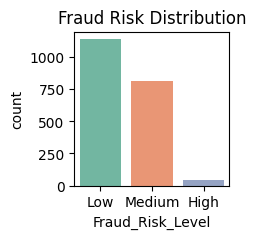

1141 817 42


In [ ]:
# visualisation of risk level

plt.figure(figsize=(2,2))
sns.countplot(x='Fraud_Risk_Level', data=df, palette='Set2')
plt.title("Fraud Risk Distribution")
plt.show()
# counting the no of low,mid and high in fraud risk level
count1 = (df['Fraud_Risk_Level'] == 'Low').sum()  # safer, works even if value not present
count2 = (df['Fraud_Risk_Level'] == 'Medium').sum()
count3 = (df['Fraud_Risk_Level'] == 'High').sum()
print(count1,count2,count3)

In [ ]:
#  Clean Combined Data (avoid “nan” in text)
df["Combined_Data"] = df[[
    "Name_clean", "Gender_clean", "DOB", "Document_type_clean", "Document_Number", "Address_clean"
]].apply(lambda x: ' '.join(x.fillna('missing').astype(str)), axis=1)

In [ ]:
df.head()

,Name,Gender,DOB,Document_Type,Document_Number,Address,Name_clean,Address_clean,Gender_clean,Document_type_clean,Document_format,Combined_Data,Duplicate_Group_ID,Fraud_Risk_Score,Fraud_Risk_Level
0,Mohanlal Sinha,Other,04-08-1975,Passport,K3935412,"866, Borah Street, Hubli–Dharwad-639425",mohanlal sinha,866 borah street hublidharwad639425,other,passport,True,mohanlal sinha other 04-08-1975 passport K3935...,-1,0.0,Low
1,Emir Gola,Male,12-03-1993,PAN,CCXHG1852M,"H.No. 19, De Zila, North Dumdum 451695",emir gola,hno 19 de zila north dumdum 451695,male,pan,True,emir gola male 12-03-1993 pan CCXHG1852M hno 1...,-1,0.0,Low
2,Krish D’Alia,Female,11-12-1974,PAN,QDBHD4336T,"H.No. 993, Sur Street, Uluberia 045795",krish dalia,hno 993 sur street uluberia 045795,female,pan,True,krish dalia female 11-12-1974 pan QDBHD4336T h...,-1,0.0,Low
3,Sana Khatri,Other,NaN,Passport,V9387476,"H.No. 00, Vasa Nagar, Bhalswa Jahangir Pur-818798",sana khatri,hno 00 vasa nagar bhalswa jahangir pur818798,other,passport,True,sana khatri other missing passport V9387476 hn...,-1,0.3,Medium
4,Raghav Mahajan,Female,28-12-1977,Aadhaar,8961 3216 2241,"75/993, Sahota Road, Rampur-792972",raghav mahajan,75993 sahota road rampur792972,female,aadhaar,False,raghav mahajan female 28-12-1977 aadhaar 8961 ...,-1,0.4,Medium


In [ ]:

# Now save final cleaned version
df.to_csv("/content/sample_data/Output_of_modelling_part1.csv", index=False)
print("✅ Final processed file saved as: kyc_final_processed.csv (empty cells handled)")


✅ Final processed file saved as: kyc_final_processed.csv (empty cells handled)


In [ ]:
df.head()

,Name,Gender,DOB,Document_Type,Document_Number,Address,Name_clean,Address_clean,Gender_clean,Document_type_clean,Document_format,Combined_Data,Duplicate_Group_ID,Fraud_Risk_Score,Fraud_Risk_Level
0,Mohanlal Sinha,Other,04-08-1975,Passport,K3935412,"866, Borah Street, Hubli–Dharwad-639425",mohanlal sinha,866 borah street hublidharwad639425,other,passport,True,mohanlal sinha other 04081975 passport K393541...,-1,0.0,Low
1,Emir Gola,Male,12-03-1993,PAN,CCXHG1852M,"H.No. 19, De Zila, North Dumdum 451695",emir gola,hno 19 de zila north dumdum 451695,male,pan,True,emir gola male 12031993 pan CCXHG1852M hno 19 ...,-1,0.0,Low
2,Krish D’Alia,Female,11-12-1974,PAN,QDBHD4336T,"H.No. 993, Sur Street, Uluberia 045795",krish dalia,hno 993 sur street uluberia 045795,female,pan,True,krish dalia female 11121974 pan QDBHD4336T hno...,-1,0.0,Low
3,Sana Khatri,Other,Unknown,Passport,V9387476,"H.No. 00, Vasa Nagar, Bhalswa Jahangir Pur-818798",sana khatri,hno 00 vasa nagar bhalswa jahangir pur818798,other,passport,True,sana khatri other nan passport V9387476 hno 00...,-1,0.3,Medium
4,Raghav Mahajan,Female,28-12-1977,Aadhaar,8961 3216 2241,"75/993, Sahota Road, Rampur-792972",raghav mahajan,75993 sahota road rampur792972,female,aadhaar,False,raghav mahajan female 28121977 aadhaar 8961 32...,-1,0.4,Medium
